In [2]:
import pandas as pd

In [3]:
init_df = pd.read_csv('./data/events_2023.csv')

In [4]:
init_df.shape

(13793502, 7)

In [5]:
init_df.sample(5)

,Unnamed: 0,Time,Action,ConditionName,Priority,Actor,AreaName
5264583,5264583,2023-05-21 05:32:24.100,ACK,ALARM,96.0,operator,243_0_ESD
10822141,10822141,2023-07-25 07:07:21.963,OK,PVLOW,0.0,NaN,130
2507620,2507620,2023-02-08 06:34:44.300,NaN,CHANGE,0.0,NaN,GAS_241
5874867,5874867,2023-05-25 22:35:46.573,NaN,OK,0.0,NaN,430
12243045,12243045,2023-08-16 08:15:12.600,OK,ALARM,16.0,NaN,FIRE_BC


#### Delete duplicated column

In [6]:
init_df = init_df.drop(['Unnamed: 0'], axis=1)
init_df.head()

,Time,Action,ConditionName,Priority,Actor,AreaName
0,2023-01-24 21:07:05.013,NaN,OFFNRM,0.0,NaN,130
1,2023-01-24 21:07:05.013,NaN,OFFNRM,0.0,NaN,130
2,2023-01-24 21:07:05.013,NaN,OFFNRM,0.0,NaN,130
3,2023-01-24 21:07:05.013,NaN,OFFNRM,0.0,NaN,130
4,2023-01-24 21:07:05.013,NaN,OFFNRM,0.0,NaN,130


In [7]:
init_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13793502 entries, 0 to 13793501
Data columns (total 6 columns):
 #   Column         Dtype  
---  ------         -----  
 0   Time           object 
 1   Action         object 
 2   ConditionName  object 
 3   Priority       float64
 4   Actor          object 
 5   AreaName       object 
dtypes: float64(1), object(5)
memory usage: 631.4+ MB


#### Change type of Time column to datetime and add 5 hours (UTC+5)

In [8]:
# Add to Time 5 hours (UTC+5) ##DO NOT RUN TWICE
from datetime import timedelta

init_df['Time'] = pd.to_datetime(init_df['Time']) + timedelta(hours=5)
init_df.head()


,Time,Action,ConditionName,Priority,Actor,AreaName
0,2023-01-25 02:07:05.013,NaN,OFFNRM,0.0,NaN,130
1,2023-01-25 02:07:05.013,NaN,OFFNRM,0.0,NaN,130
2,2023-01-25 02:07:05.013,NaN,OFFNRM,0.0,NaN,130
3,2023-01-25 02:07:05.013,NaN,OFFNRM,0.0,NaN,130
4,2023-01-25 02:07:05.013,NaN,OFFNRM,0.0,NaN,130


##### Copy init_df to df

In [9]:
df = init_df.copy()

### We should floor (trunc) Time to group them after by that period

In [10]:
# Round time to halfhour, i.e. 11:15 - > 11 : 00 , 11:44 -> 11:30
df['Time'] = df['Time'].dt.floor(freq='30T')
df.head()
    

,Time,Action,ConditionName,Priority,Actor,AreaName
0,2023-01-25 02:00:00,NaN,OFFNRM,0.0,NaN,130
1,2023-01-25 02:00:00,NaN,OFFNRM,0.0,NaN,130
2,2023-01-25 02:00:00,NaN,OFFNRM,0.0,NaN,130
3,2023-01-25 02:00:00,NaN,OFFNRM,0.0,NaN,130
4,2023-01-25 02:00:00,NaN,OFFNRM,0.0,NaN,130


In [11]:
from datetime import timedelta

df['Time'] = df['Time'] + timedelta(minutes=30)

In [12]:
df.head()

,Time,Action,ConditionName,Priority,Actor,AreaName
0,2023-01-25 02:30:00,NaN,OFFNRM,0.0,NaN,130
1,2023-01-25 02:30:00,NaN,OFFNRM,0.0,NaN,130
2,2023-01-25 02:30:00,NaN,OFFNRM,0.0,NaN,130
3,2023-01-25 02:30:00,NaN,OFFNRM,0.0,NaN,130
4,2023-01-25 02:30:00,NaN,OFFNRM,0.0,NaN,130


### We should shift time to 30 Minutes forward, Because we will calculate count of events postfactum by some timestamp

## Merge Assets-Units dataframe

In [13]:
assets = pd.read_csv('./data/Assets.csv', sep=';', encoding='cp1251')
assets.head()

,Asset,Unit
0,211,Unit_1
1,211_0_DCS,Unit_1
2,211_0_ESD,Unit_1
3,221,Unit_1
4,221_0_DCS,Unit_1


In [14]:
merged_assets_df = df.merge(assets, left_on='AreaName', right_on='Asset', how='left').drop('Asset', axis=1)
merged_assets_df.sample(5)

,Time,Action,ConditionName,Priority,Actor,AreaName,Unit
3787744,2023-04-23 11:30:00,NaN,PVHIGH,0.0,NaN,130,GS
13707105,2023-09-24 11:00:00,ACK,ALARM,96.0,operator,FIRE_BBCS,NaN
1717391,2023-02-14 06:00:00,NaN,ALARM,16.0,NaN,FIRE_Admin_CPF,NaN
2559873,2023-02-08 11:00:00,NaN,CHANGE,96.0,operator,353_1_DCS,Unit_2
8007783,2023-06-14 00:00:00,F,ALARM,0.0,NaN,110,GS


In [15]:
# count rows with unit and without
print(f'Without unit: {merged_assets_df[merged_assets_df.Unit.isna()].shape[0]}')
print(f'With unit: {merged_assets_df[merged_assets_df.Unit.notna()].shape[0]}')

Without unit: 1801884
With unit: 11996692


### Divide merged_df to Units df

In [16]:
## unit 1 df
unit1_df = merged_assets_df[merged_assets_df['Unit'] == 'Unit_1']
unit1_df.shape[0]

1191293

In [17]:
## unit 2 df
unit2_df = merged_assets_df[merged_assets_df['Unit'] == 'Unit_2']
unit2_df.shape[0]

3132386

In [18]:
## unit 3 df
unit3_df = merged_assets_df[merged_assets_df['Unit'] == 'Unit_3']
unit3_df.shape[0]

1154053

In [19]:
## unit 4 df - TVS - HWS
unit4_df = merged_assets_df[merged_assets_df['Unit'] == 'Unit_4']
unit4_df.shape[0]

2339112

In [20]:
## unit 5 df - Gathering System
unit5_df = merged_assets_df[merged_assets_df['Unit'] == 'GS']
unit5_df.shape[0]

4179848

### Extract System alarms

In [21]:
##system alarms
mask1 = merged_assets_df['Actor'].isna() & merged_assets_df['Action'].isna()
priorities = (16., 32., 48.)
mask2 =merged_assets_df['Priority'].isin(priorities)
system_signs = ['DIAG', 'WARNING', 'REPLICATION', 'MANCOMPERROR', 'COMMS']
system_alarms = merged_assets_df[merged_assets_df['ConditionName'].isin(system_signs) & mask1 & mask2]
system_alarms.shape[0]

33565

## Work with separate Unit

In [22]:
# unit1_df = Unit1, unit2_df = Unit2, unit3_df = Unit3, unit4_df - HWS, unit5_df = GS
unit_df = unit1_df.copy() ## chose Unit 1

### Extract All alarms and all actions

In [23]:
all_actions = unit_df[unit_df['Actor'].notna()]
alarms = unit_df[unit_df['Actor'].isna() & unit_df['Action'].isna()]
print(f'Actions count: {all_actions.shape[0]}, Alarms count: {alarms.shape[0]}')

Actions count: 567231, Alarms count: 323802


### Divide action to Acknowledges and Changes

In [24]:
acks = all_actions[all_actions['Action'].fillna('No Action').str.contains('ACK')]
changes = all_actions[all_actions['ConditionName'] == 'CHANGE']
print(f'Changes count: {changes.shape[0]}, Acknowldeges count: {acks.shape[0]}')
all_actions.sample(5)

Changes count: 437299, Acknowldeges count: 129141


,Time,Action,ConditionName,Priority,Actor,AreaName,Unit
2074655,2023-02-17 14:00:00,NaN,CHANGE,96.0,operator,GAS_221,Unit_1
9783350,2023-07-09 05:00:00,ACK,PVLOW,96.0,operator,484_0_DCS,Unit_1
5254481,2023-05-13 21:30:00,NaN,CHANGE,96.0,operator,484_0_DCS,Unit_1
11960284,2023-08-10 23:00:00,ACK,PVLOW,96.0,operator,484_0_DCS,Unit_1
1065112,2023-01-17 07:30:00,NaN,CHANGE,96.0,operator,484_0_DCS,Unit_1


### Delete not needed columns for Alarms and divide alarms

In [25]:
alarms = alarms.drop(['Actor','Action', 'AreaName'], axis=1)

In [26]:
alarms.sample(5)

,Time,ConditionName,Priority,Unit
9023068,2023-06-08 13:00:00,PVLL,48.0,Unit_1
5094537,2023-05-03 20:00:00,PVHIGH,32.0,Unit_1
2065909,2023-02-20 12:00:00,CHANGE,0.0,Unit_1
4887820,2023-05-31 06:30:00,DISABL,0.0,Unit_1
12156077,2023-08-06 12:00:00,ALARM,0.0,Unit_1


### Divide alarms by priorities

In [27]:
## check alarms by priorities
alarms.Priority.value_counts()

Priority
32.0    165777
0.0     128132
48.0     26546
16.0      3162
96.0         1
Name: count, dtype: int64

In [28]:
# /** [Priority] 0 - JOURNAL, 15 - system, 16 - Low, 32 - HIGH, 48 - URGENT, 96 - OP **/
## divide alarms to only with journal and alarms with low, high and urgent priorities and system alarms
journal_alarms = alarms[alarms['Priority'] == 0]
low_alarms = alarms[alarms['Priority'] == 16]
high_alarms = alarms[alarms['Priority'] == 32]
urgent_alarms = alarms[alarms['Priority'] == 48]
print(f'Alarms count: {alarms.shape[0]},\n\
      Journal alarms count: {journal_alarms.shape[0]},\n\
      Low Priority alarms count: {low_alarms.shape[0]},\n\
      High Priority alarms count: {high_alarms.shape[0]},\n\
      Urgent Priority alarms count: {urgent_alarms.shape[0]},\n\
      ')

Alarms count: 323802,
      Journal alarms count: 128132,
      Low Priority alarms count: 3162,
      High Priority alarms count: 165777,
      Urgent Priority alarms count: 26546,
      


#### Extract BAD BP alarms

In [29]:
badpv_alarms = alarms[alarms['ConditionName'] == 'BAD PV']
print(f'BAD PV alarms count: {badpv_alarms.shape[0]}')

BAD PV alarms count: 91664


#### Check consistensy of dfs

In [30]:
system_alarms.sample(5)

,Time,Action,ConditionName,Priority,Actor,AreaName,Unit
6021035,2023-05-25 11:30:00,NaN,COMMS,48.0,NaN,F&G,NaN
879560,2023-01-05 13:00:00,NaN,COMMS,48.0,NaN,F&G,NaN
12210174,2023-08-20 10:00:00,NaN,COMMS,32.0,NaN,322,Unit_4
4530027,2023-04-29 23:30:00,NaN,REPLICATION,16.0,NaN,$SRV430SRV0002,NaN
6671070,2023-05-24 03:30:00,NaN,COMMS,16.0,NaN,130,GS


In [31]:
journal_alarms.sample(5)

,Time,ConditionName,Priority,Unit
1072908,2023-01-17 19:00:00,CHANGE,0.0,Unit_1
8958732,2023-06-01 10:30:00,DISABL,0.0,Unit_1
12519846,2023-09-15 12:00:00,CHANGE,0.0,Unit_1
4878183,2023-05-31 06:30:00,DISABL,0.0,Unit_1
9165122,2023-06-03 04:00:00,DISABL,0.0,Unit_1


In [32]:
low_alarms.sample(5)

,Time,ConditionName,Priority,Unit
44684,2023-01-13 17:00:00,ALARM,16.0,Unit_1
4916116,2023-05-19 02:30:00,ALARM,16.0,Unit_1
5375387,2023-05-27 08:00:00,ALARM,16.0,Unit_1
846436,2023-01-08 09:30:00,ALARM,16.0,Unit_1
4488025,2023-04-25 21:30:00,ALARM,16.0,Unit_1


In [33]:
high_alarms.sample(5)

,Time,ConditionName,Priority,Unit
9246774,2023-06-07 22:00:00,PVLOW,32.0,Unit_1
1054286,2023-01-21 05:30:00,BAD PV,32.0,Unit_1
842930,2023-01-10 06:00:00,PVHIGH,32.0,Unit_1
9692829,2023-07-19 18:00:00,BAD PV,32.0,Unit_1
776053,2023-01-11 22:30:00,BAD PV,32.0,Unit_1


In [34]:
urgent_alarms.sample(5)

,Time,ConditionName,Priority,Unit
5292453,2023-05-23 16:00:00,ALARM,48.0,Unit_1
12563152,2023-09-04 20:00:00,PVLOLO,48.0,Unit_1
1178359,2023-02-04 11:30:00,OFFNRM,48.0,Unit_1
5472769,2023-05-28 15:30:00,ALARM,48.0,Unit_1
12662531,2023-09-24 15:30:00,ALARM,48.0,Unit_1


In [35]:
badpv_alarms.sample(5)

,Time,ConditionName,Priority,Unit
9332737,2023-06-28 13:00:00,BAD PV,32.0,Unit_1
5212191,2023-05-11 10:30:00,BAD PV,32.0,Unit_1
9861977,2023-07-14 14:00:00,BAD PV,32.0,Unit_1
12510521,2023-09-16 14:30:00,BAD PV,32.0,Unit_1
3220207,2023-03-05 07:00:00,BAD PV,32.0,Unit_1


### Groupby alarm dfs by hour

In [36]:
journal_alarms_grouped = journal_alarms.groupby('Time')['Unit'].agg('count').reset_index().rename(columns={'Unit': 'JournalAlarmCount'})
low_alarms_grouped = low_alarms.groupby('Time')['Unit'].agg('count').reset_index().rename(columns={'Unit': 'LowAlarmCount'})
high_alarms_grouped = high_alarms.groupby('Time')['Unit'].agg('count').reset_index().rename(columns={'Unit': 'HighAlarmCount'})
urgent_alarms_grouped = urgent_alarms.groupby('Time')['Unit'].agg('count').reset_index().rename(columns={'Unit': 'UrgentAlarmCount'})
badpv_alarms_grouped = badpv_alarms.groupby('Time')['Unit'].agg('count').reset_index().rename(columns={'Unit': 'BADPVCount'})
system_alarms_grouped = system_alarms.groupby('Time')['Unit'].agg('count').reset_index().rename(columns={'Unit': 'SystemAlarmCount'})
alarms_grouped = alarms.groupby('Time')['Unit'].agg('count').reset_index().rename(columns={'Unit': 'AllAlarmCount'})

## Merge to Final Alarms df

In [57]:
# create final alarm df
dummy_df = journal_alarms_grouped.merge(low_alarms_grouped, how='outer', on='Time')
dummy_df = dummy_df.merge(high_alarms_grouped, how='outer', on='Time')
dummy_df = dummy_df.merge(urgent_alarms_grouped, how='outer', on='Time')
dummy_df = dummy_df.merge(badpv_alarms_grouped, how='outer', on='Time')
dummy_df = dummy_df.merge(system_alarms_grouped, how='outer', on='Time')
dummy_df = dummy_df.merge(alarms_grouped, how='outer', on='Time')
alarm_count = dummy_df.fillna(0).reset_index(drop=True)
alarm_count.sample(5)

,Time,JournalAlarmCount,LowAlarmCount,HighAlarmCount,UrgentAlarmCount,BADPVCount,SystemAlarmCount,AllAlarmCount
6509,2023-08-26 22:30:00,3.0,0.0,7.0,1.0,0.0,0.0,11.0
6808,2023-09-14 02:00:00,2.0,0.0,4.0,0.0,0.0,0.0,6.0
11678,2023-09-07 05:30:00,0.0,0.0,4.0,0.0,0.0,0.0,4.0
10845,2023-07-26 14:00:00,0.0,0.0,2.0,0.0,0.0,0.0,2.0
11412,2023-08-19 12:00:00,0.0,0.0,2.0,0.0,0.0,0.0,2.0


## Group changes and acks by half hour

In [38]:
acks_grouped = acks.groupby('Time').size().reset_index().rename(columns={0: 'AcksCount'}).fillna(0)
acks_grouped.head(5)

,Time,AcksCount
0,2023-01-01 04:30:00,10
1,2023-01-01 05:00:00,2
2,2023-01-01 05:30:00,3
3,2023-01-01 06:00:00,5
4,2023-01-01 06:30:00,8


In [39]:
changes_grouped = changes.groupby('Time').size().reset_index().rename(columns={0: 'ChangesCount'}).fillna(0)
changes_grouped.head(5)

,Time,ChangesCount
0,2023-01-01 04:00:00,5
1,2023-01-01 04:30:00,14
2,2023-01-01 05:00:00,1
3,2023-01-01 05:30:00,74
4,2023-01-01 06:00:00,28


## Calculate loading = 1*acks + 1*changes

In [40]:
loading = changes_grouped.merge(acks_grouped, how='outer', on='Time').fillna(0)
WEIGHT_OF_ACKS = 1
loading['Loading'] = loading['ChangesCount'] + WEIGHT_OF_ACKS * loading['AcksCount']
loading = loading.loc[:, ['Time', 'Loading']].reset_index(drop=True).fillna(0)
loading.head(5)

,Time,Loading
0,2023-01-01 04:00:00,5.0
1,2023-01-01 04:30:00,24.0
2,2023-01-01 05:00:00,3.0
3,2023-01-01 05:30:00,77.0
4,2023-01-01 06:00:00,33.0


## Drift loading 30 min backward 

In [41]:
loading = loading.copy().rename(columns={'Loading': 'AfterhhLoading'})
loading['Time'] = loading['Time'] - timedelta(minutes=30)
loading.head(5)

,Time,AfterhhLoading
0,2023-01-01 03:30:00,5.0
1,2023-01-01 04:00:00,24.0
2,2023-01-01 04:30:00,3.0
3,2023-01-01 05:00:00,77.0
4,2023-01-01 05:30:00,33.0


## Merge acks, changes and Loading

In [42]:
merged_acks_changes = acks_grouped.merge(changes_grouped, how='outer', on='Time').reset_index(drop=True).fillna(0)
merged_loading = merged_acks_changes.merge(loading, how='right', on='Time').sort_values(by='Time').reset_index(drop=True).fillna(0)
merged_loading.head(5)

,Time,AcksCount,ChangesCount,AfterhhLoading
0,2023-01-01 03:30:00,0.0,0.0,5.0
1,2023-01-01 04:00:00,0.0,5.0,24.0
2,2023-01-01 04:30:00,10.0,14.0,3.0
3,2023-01-01 05:00:00,2.0,1.0,77.0
4,2023-01-01 05:30:00,3.0,74.0,33.0


### Create Month and Hour features

In [59]:
alarm_count['Month'] = alarm_count['Time'].dt.month
alarm_count['Hour'] = alarm_count['Time'].dt.hour

## Create final df for Unit

In [89]:
final_df = alarm_count.merge(merged_loading, how='inner', on='Time').fillna(0).sort_values(by='Time')
final_df.head(10)

,Time,JournalAlarmCount,LowAlarmCount,HighAlarmCount,UrgentAlarmCount,BADPVCount,SystemAlarmCount,AllAlarmCount,Month,Hour,AcksCount,ChangesCount,AfterhhLoading
0,2023-01-01 03:30:00,2.0,0.0,0.0,0.0,0.0,0.0,2.0,1,3,0.0,0.0,5.0
7307,2023-01-01 04:30:00,0.0,0.0,10.0,0.0,0.0,0.0,10.0,1,4,10.0,14.0,3.0
7308,2023-01-01 05:00:00,0.0,0.0,2.0,0.0,1.0,0.0,2.0,1,5,2.0,1.0,77.0
7309,2023-01-01 05:30:00,0.0,0.0,3.0,0.0,1.0,0.0,3.0,1,5,3.0,74.0,33.0
7310,2023-01-01 06:00:00,0.0,0.0,5.0,0.0,1.0,0.0,5.0,1,6,5.0,28.0,100.0
1,2023-01-01 06:30:00,3.0,0.0,7.0,0.0,5.0,0.0,10.0,1,6,8.0,92.0,26.0
7311,2023-01-01 07:00:00,0.0,0.0,12.0,0.0,8.0,0.0,12.0,1,7,12.0,14.0,68.0
2,2023-01-01 07:30:00,8.0,0.0,19.0,0.0,17.0,2.0,27.0,1,7,15.0,53.0,44.0
7312,2023-01-01 08:00:00,0.0,0.0,66.0,0.0,66.0,0.0,66.0,1,8,27.0,17.0,42.0
3,2023-01-01 08:30:00,3.0,0.0,13.0,0.0,13.0,1.0,16.0,1,8,14.0,28.0,103.0


### Check features for correlation

In [90]:
corrs = dict()
for col in final_df.columns:
    target = 'AfterhhLoading'   
    if not (col == 'Time' or col == target):
        corr = round(final_df[[col, target]].corr().iloc[0, 1],2)
        corrs[col] = corr
pd.Series(corrs).to_frame().rename(columns={0: 'Correlation'}).sort_values(by='Correlation', ascending=False)

,Correlation
ChangesCount,0.40
AcksCount,0.34
HighAlarmCount,0.20
AllAlarmCount,0.16
UrgentAlarmCount,0.15
LowAlarmCount,0.10
BADPVCount,0.10
JournalAlarmCount,0.08
SystemAlarmCount,0.02
Month,-0.01


### Show distribution of Target feature

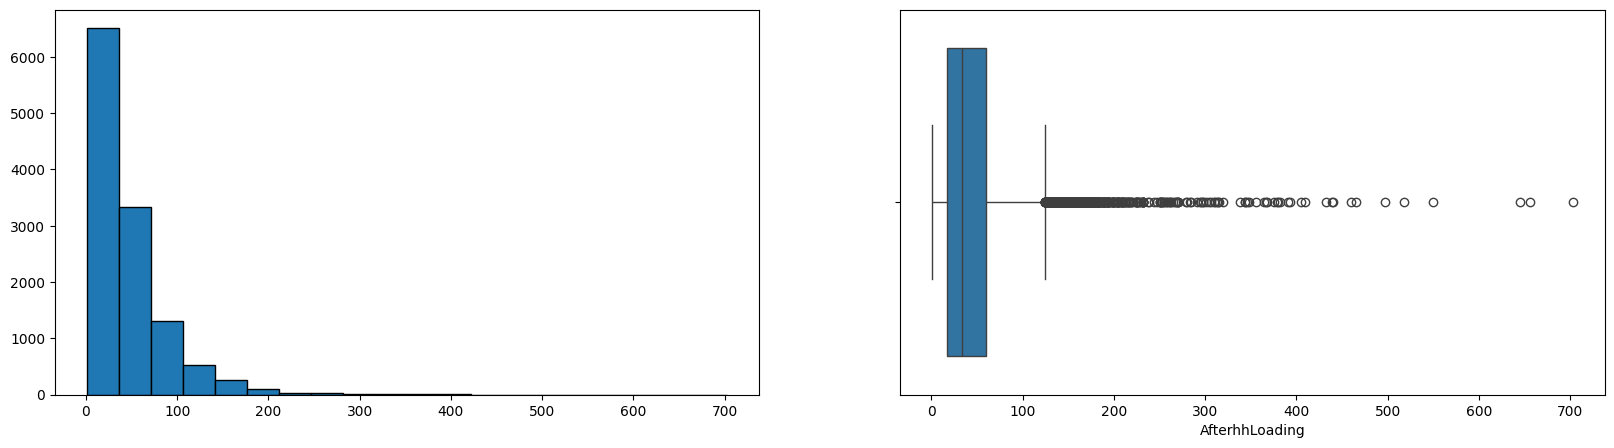

In [112]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))
target = final_df['AfterhhLoading']
axes[0].hist(target, bins=20, edgecolor='black')
axes[1] = sns.boxplot(data=final_df, x='AfterhhLoading')

#### We see a big amount of outliers in target feature

## Get rid of outliers from Target column

In [117]:
def outliers_iqr_mod(data, feature, left=2, right=1):
    '''
    Function for remove oultiers'''
    x = data[feature]
    quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75)
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr*left)
    upper_bound = quartile_3 + (iqr*right)
    outliers = data[(x < lower_bound) | (x > upper_bound)]
    cleaned = data[(x >= lower_bound) & (x <= upper_bound)]
    return outliers, cleaned

In [118]:
outliers, cleaned_df = outliers_iqr_mod(final_df, 'AfterhhLoading')
print(f'Число выбросов по методу Тьюки: {outliers.shape[0]}')
print(f'Результирующее число записей: {cleaned_df.shape[0]}')

Число выбросов по методу Тьюки: 1051
Результирующее число записей: 11083


### Check again distribution and boxplot

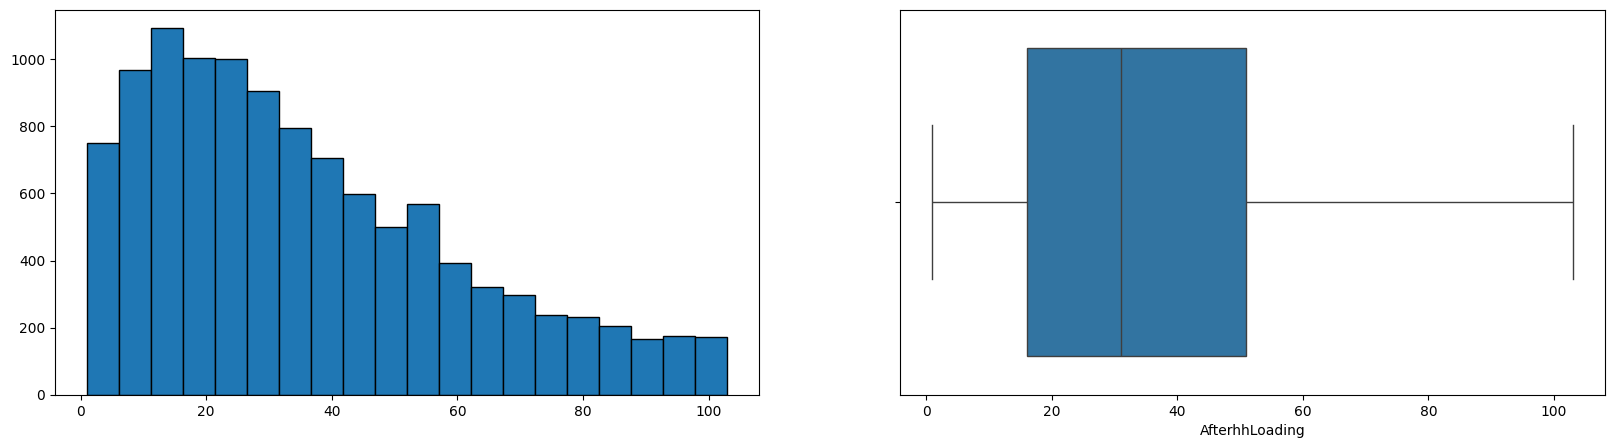

In [130]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))
target = cleaned_df['AfterhhLoading']
axes[0].hist(target, bins=20, edgecolor='black')
axes[1] = sns.boxplot(data=cleaned_df, x='AfterhhLoading')

#### Show pairplot

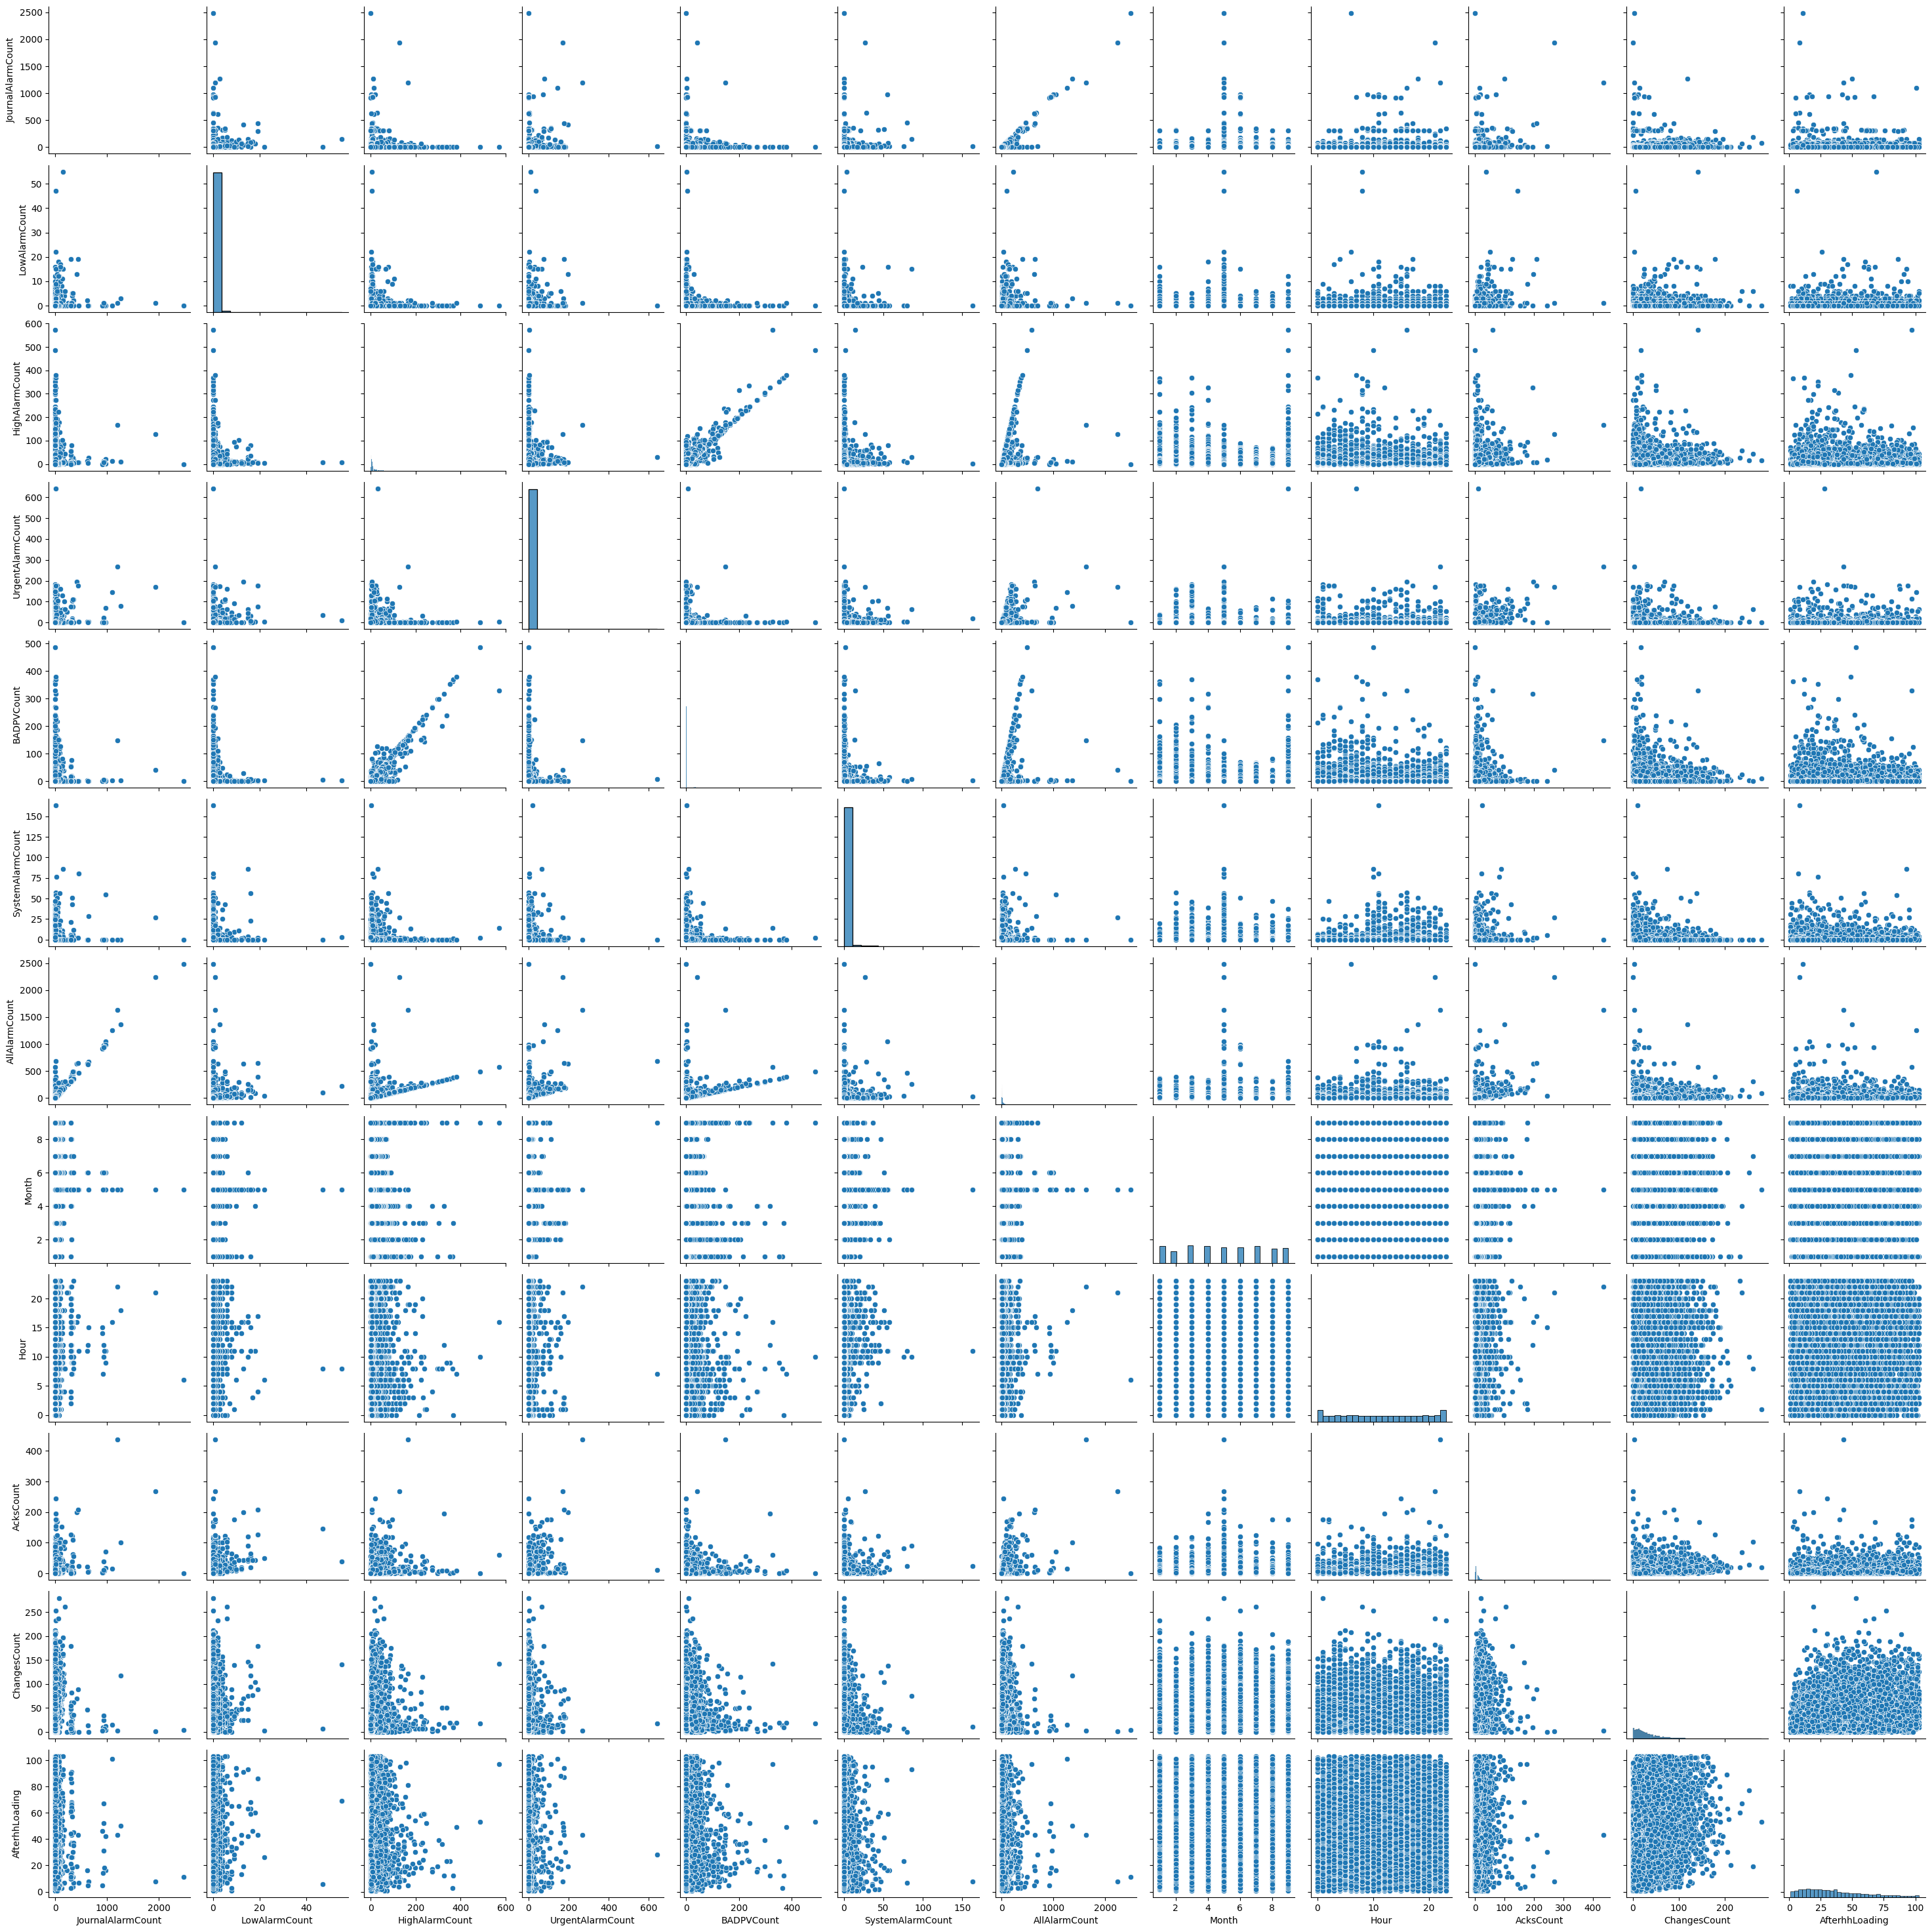

In [121]:
sns.pairplot(cleaned_df)

In [122]:
cleaned_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11083 entries, 0 to 12133
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Time               11083 non-null  datetime64[ns]
 1   JournalAlarmCount  11083 non-null  float64       
 2   LowAlarmCount      11083 non-null  float64       
 3   HighAlarmCount     11083 non-null  float64       
 4   UrgentAlarmCount   11083 non-null  float64       
 5   BADPVCount         11083 non-null  float64       
 6   SystemAlarmCount   11083 non-null  float64       
 7   AllAlarmCount      11083 non-null  float64       
 8   Month              11083 non-null  int32         
 9   Hour               11083 non-null  int32         
 10  AcksCount          11083 non-null  float64       
 11  ChangesCount       11083 non-null  float64       
 12  AfterhhLoading     11083 non-null  float64       
dtypes: datetime64[ns](1), float64(10), int32(2)
memory usage: 1.1 MB


In [124]:
cleaned_df.describe().round(2)

,Time,JournalAlarmCount,LowAlarmCount,HighAlarmCount,UrgentAlarmCount,BADPVCount,SystemAlarmCount,AllAlarmCount,Month,Hour,AcksCount,ChangesCount,AfterhhLoading
count,11083,11083.00,11083.00,11083.00,11083.00,11083.00,11083.00,11083.00,11083.00,11083.00,11083.00,11083.00,11083.00
mean,2023-05-16 05:55:17.729856768,9.22,0.22,12.52,1.76,7.08,0.75,23.74,4.98,11.53,9.26,32.72,36.10
min,2023-01-01 03:30:00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00
25%,2023-03-12 10:15:00,0.00,0.00,3.00,0.00,0.00,0.00,4.00,3.00,6.00,3.00,11.00,16.00
50%,2023-05-13 11:30:00,1.00,0.00,6.00,0.00,0.00,0.00,10.00,5.00,11.00,6.00,23.00,31.00
75%,2023-07-21 14:45:00,4.00,0.00,12.00,0.00,4.00,0.00,25.00,7.00,18.00,11.00,44.00,51.00
max,2023-09-30 23:30:00,2483.00,55.00,572.00,641.00,487.00,163.00,2483.00,9.00,23.00,437.00,279.00,103.00
std,NaN,52.28,1.14,22.49,11.46,20.50,3.84,61.63,2.55,6.94,12.80,31.38,24.74


In [125]:
cleaned_df['AfterhhLoading'].skew()

0.7818657562811243

In [126]:
import  numpy as np

### SQRT Transformation of target

In [129]:
sqrt_target = np.sqrt(target)

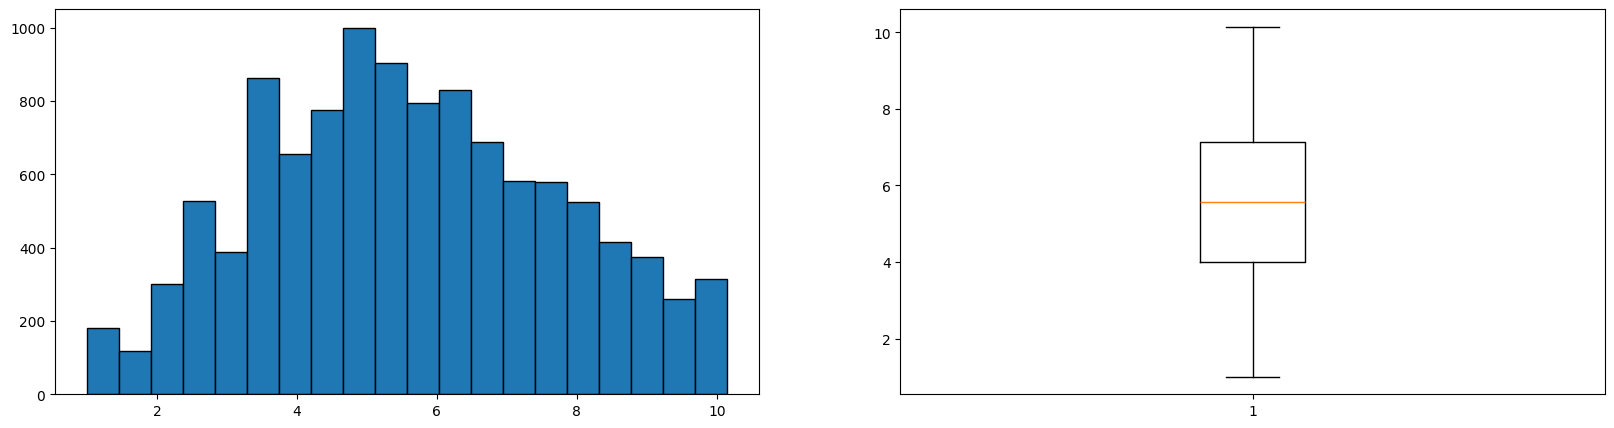

In [132]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))
axes[0].hist(sqrt_target, bins=20, edgecolor='black')
axes[1].boxplot(sqrt_target);

## Обучаем и проверяем

In [171]:
y = cleaned_df['AfterhhLoading']
X = cleaned_df.drop(['AfterhhLoading', 'Time'], axis=1)

In [198]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import r2_score

In [206]:
models = {
    'lr': LinearRegression,
    'rf': RandomForestRegressor,
    'gb': GradientBoostingRegressor,
    'lgr': LogisticRegression
}
scores = []
niter = 100
for name, model in models.items():
    regr = model()   
    for i in range(niter):
        X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7)
        regr.fit(X_train, y_train)
        predict_test = regr.predict(X_test)
        score = r2_score(y_test, predict_test)
        scores.append([name, score])

/home/fitlemon/code/vkr/.venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/fitlemon/code/vkr/.venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.ht

In [209]:
scores_df = pd.DataFrame(scores).rename(columns={0:"Model", 1: "R2Score"})

In [210]:
scores_df.groupby('Model')['R2Score'].mean()

Model
gb     0.164835
lgr   -0.399733
lr     0.134161
rf     0.111606
Name: R2Score, dtype: float64